<a href="https://colab.research.google.com/github/patofw/imf_master/blob/master/Notebooks/LDA_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install -U pyspellchecker
!pip install emoji
!pip install pyLDAvis

Requirement already up-to-date: pyspellchecker in /usr/local/lib/python3.6/dist-packages (0.5.4)
     |████████████████████████████████| 1.6MB 4.6MB/s 
     |████████████████████████████████| 552kB 23.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=6b747b4902af8cc896c2c1778ebf15873befdd76c12a45bb3de88b12233106c9
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=716fe43dd325be5077448878d1b98fa45a1e00a83ac9bc2c8a437aec7d1be2aa
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


# LDA y Modelado por Temas

El modelado por temas es uno de los casos de usos más comunes en NLP ya que nos permite utilizar métodos **no supervisados** para organizar grandes cantidades de información. Por ejemplo, es bastante práctico para ordenar artículos de revistas por tópico, películas por género, canciones por tema, etc. 

Hay varias formas de hacerlo, pero el algoritmo más común es Latent Dirichlet Allocation (LDA), con el cuál trabajaremos en este tutorial. 

En resumen: 
LDA es una forma de aprendizaje no supervisado que ve los documentos como bolsas de palabras (bag of words, es decir, el orden no importa). LDA funciona haciendo primero una suposición clave: la forma en que se generó un documento fue escogiendo un conjunto de temas y luego para cada tema escogiendo un conjunto de palabras. 

Para ello, hace lo siguiente para cada documento *m*:

1. Supongamos que hay temas k en todos los documentos
2. Distribuímos estos temas k en el documento m (al azar).
3. Para cada palabra w del documento m, se asume que su tema es incorrecto pero que cada otra palabra está asignada el tema correcto.
Probablemente asigne a la palabra w un tema basado en dos cosas:
- qué temas están en el documento m
- cuántas veces se ha asignado a la palabra w un tema particular en todos los documentos (esta distribución se llama β)
4. Se Repite este proceso un número de veces para cada documento y ¡ya está!

En este caso, vamos a realizar un LDA con los Tweets de Elon Musk. Veamos de qué le gusta hablar en Redes Sociales


In [2]:
import re
import tqdm
import pandas as pd
import numpy as np 
from nltk.tokenize import word_tokenize, TweetTokenizer # tokenizador
from string import punctuation 
from nltk.corpus import stopwords # elimina palabras de poco valor
from nltk.stem.wordnet import WordNetLemmatizer # stemming lemming
# Instalamos algunas de las APIs y herramientas de NLTK
import nltk
from spellchecker import SpellChecker

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
# Helpers 


stopwords_ = set(stopwords.words('english') + list(punctuation)+ ["rt"]) # palabras de poco valor
tknzr = TweetTokenizer() # Tokenizador para Tweeter por NLTK
spell = SpellChecker() # Corrección gramatical
# Asignamos algunas funciones de limpieza básica
replacements = [
            '((www\.[^\s]+)|(https?://[^\s]+))', # url_replace 
            '@[^\s]+', # user_replace 
            '#([^\s]+)', # hash_replace
            "[^A-Za-z ]+"  # eliminamos todo lo que no sea una letra
            ]
# Re nos permite compilar varias transformaciones en un solo iterador, 
# así nos evitamos iterar varias veces por el mismo documento, incrementando eficiencia. 
regex = re.compile('|'.join(r for r in replacements),re.IGNORECASE)

<input>:9: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \s
<input>:11: DeprecationWarning: invalid escape sequence \s
<input>:9: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \s
<input>:11: DeprecationWarning: invalid escape sequence \s
<input>:9: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \s
<input>:11: DeprecationWarning: invalid escape sequence \s
<input>:9: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \s
<input>:11: DeprecationWarning: invalid escape sequence \s
<input>:9: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \s
<input>:11: DeprecationWarning: invalid escape sequence \s
<input>:9: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \s
<in

In [116]:
def stem_lemm(tweet_list):
  """
  Lemmatiza un tweeet uitlizando el lematizador de NLTK
  :param tweet_list: Un tweet tokenizado previamente
  :return: Una lista de tokens
  """
  lem = WordNetLemmatizer()
  normalized_tweet = []
  for word in tweet_list:
      normalized_text = lem.lemmatize(word,'v')
      normalized_tweet.append(normalized_text)
  return normalized_tweet
def limpia_tweets(tweet): 
  """ 
  Función práctica para limpiar y pre-procesar tweets. Incluye: 
  - Eliminación de Hashtags, urls y usuarios 
  - Tokenización 
  - lemmatizer 
  - corrector gramatical (inglés)
  :param tweet: String, cadena de texto, idealmente un Tweet
  :return: Una lista con tokens de tweet.  
  """
  # empezamos transformando a minúsculas
  clean_tweet = tweet.lower()
  # Limpiamos Usuario, Urls y Hashtags
  clean_tweet = regex.sub('', clean_tweet)
  # Añadimos limpieza de caracteres repetidos
  clean_tweet = re.sub(r'(.)\1+', r'\1\1', clean_tweet) 
  # Tokenizamos 
  clean_tweet = tknzr.tokenize(clean_tweet)
  # Quitamos las stopwords
  clean_tweet = [word for word in clean_tweet if word not in stopwords_] # nuestras stopwords
  # lemming y stemming 
  clean_tweet = stem_lemm(clean_tweet)
  # Encuentra las que tienen errores
  misspelled = spell.unknown(clean_tweet)
  # Corregimos el tweet. 
  clean_tweet = [
      spell.correction(word) if word in misspelled else word for word in clean_tweet]
  return clean_tweet

In [117]:
# Ejemplo 
tweet = '@Tesla What an amaziiiiiing night!!!!. 333 See the pics at www.fakepage.com #Party #TESLA'
limpia_tweets(tweet)

['amazing', 'night', 'see', 'pics']

# Cargamos los datos y limpieza 

In [118]:
# Data load 
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Notebooks/data/tweets_data_elonmusk.csv'
data = pd.read_csv(url, encoding='latin-1')
data.head()


,row ID,Tweet,Time,Retweet from,User
0,Row0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,Row1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [119]:
# tomamos los tweets 
tweets = data.Tweet.values 
# limpieza con nuestra funcion (toma unos minutos)
# usamos TQDM para tener estimado de tiempo en ejecutar
tweets_clean = [limpia_tweets(tweet) for tweet in tqdm.tqdm_notebook(tweets)]
# Cabecera 
tweets_clean[:4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


[['assume',
  'max',
  'acceleration',
  'gs',
  'comfortable',
  'direction',
  'feel',
  'like',
  'mild',
  'model'],
 ['bar',
  'capable',
  'transport',
  'satellite',
  'orbit',
  'crew',
  'cargo',
  'complete',
  'missions',
  'moon'],
 ['yup'],
 ['part']]

In [122]:
# Hay tweets demasiado cortos que no aportan mucho valor, eliminamos todos
# los que tienen menos de dos palabras 
# Indices de donde los tweets superan el largo de 2 palabras
mask = [i for i in range(len(tweets_clean)) if len(tweets_clean[i]) > 2]
tweets_entrenamiento = tweets[mask] # Tweets que entran al modelo 
tweets_clean = np.array(tweets_clean)[mask] # filtramos por la máscara
len(tweets_clean)

2680

In [148]:
tweets_clean[113]

['wigs', 'much', 'delete']

In [147]:
tweets_entrenamiento[113]

'Wigs me out too much. Deleting ...'

# Creación del Modelo 

Antes de crear modelo, es una buena idea inicializar un algoritmo de Ngramas. Esto unirá palabras que usualmente están juntas para que sean consideradas como un solo término. Por ejemplo Big Data, se transforma a big_data. 

## Bigrams 


In [123]:
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  

# Phraser une palabras que usualmente están juntas,
# Por ejemplo Big Data -> big_data
sentences = tweets_clean
phrases = Phrases(sentences, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
ngram_sentences = bigram[sentences] 
# Vemos el vocabulario que hemos creado 
# Sanity check 
word_freq = defaultdict(int)
for sent in ngram_sentences:
    for i in sent:
        word_freq[i] += 1
print(f'El corpus tiene {len(word_freq)} palabras') 

El corpus tiene 4809 palabras


In [124]:
# Miramos las palabras más comunes 
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['tessa',
 'model',
 'launch',
 'rocket',
 'land',
 'go',
 'car',
 'good',
 'like',
 'falcon']

## Creación del diccionario con id2word

In [125]:
import gensim.corpora as corpora
# Creamos diccionario de términos para el modelo
id2word = corpora.Dictionary(ngram_sentences)
# Creamos Corpus
texts = ngram_sentences
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Vista computadora 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [126]:
# Vista humano para un tweet
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acceleration', 1),
  ('assume', 1),
  ('comfortable', 1),
  ('direction', 1),
  ('feel', 1),
  ('gs', 1),
  ('like', 1),
  ('max', 1),
  ('mild', 1),
  ('model', 1)]]

# Construímos el Modelo LDA 

Ya tenemos todo lo que necesitamos, por lo que vamos a construir el modelo. Haremos algunas configuraciones básicas, pero la más importante es la cantidad de tópicos que queramos tener. Este número depende muchas veces de objetivos de negocio, pero también hay formas de elegir un número óptimo de tópicos. Por ahora utilizaremos prueba y error con el objetivo de ser ilustrativos. 

In [129]:
import gensim
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # Corpus que creamos
                                           id2word=id2word, # Vocab
                                           num_topics=6, # Número de tópicos
                                           random_state=100, # Semilla 
                                           update_every=1,# Dejamos por defecto
                                           chunksize=100, # Mayor número, más rápido el procesamiento
                                           passes=15, # Iteraciones 
                                           alpha='auto', # Por Defecto
                                           per_word_topics=True) 

Se han truncado las últimas 5000 líneas del flujo de salida.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different 

In [130]:
import pprint
# Vemos los resultados 
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus] # Asignamos tópicos a cada tweet 

[(0,
  '0.020*"time" + 0.018*"need" + 0.017*"say" + 0.016*"take" + 0.015*"people" + '
  '0.015*"tessa" + 0.014*"much" + 0.012*"long" + 0.011*"im" + 0.011*"high"'),
 (1,
  '0.027*"good" + 0.020*"w" + 0.018*"dragon" + 0.017*"would" + 0.013*"article" '
  '+ 0.013*"v" + 0.013*"cars" + 0.013*"next" + 0.011*"supercharger" + '
  '0.011*"really"'),
 (2,
  '0.052*"tessa" + 0.023*"go" + 0.020*"car" + 0.019*"drive" + 0.018*"thank" + '
  '0.018*"make" + 0.016*"new" + 0.013*"first" + 0.013*"mar" + 0.012*"one"'),
 (3,
  '0.047*"model" + 0.025*"like" + 0.012*"also" + 0.010*"use" + 0.010*"orbit" + '
  '0.009*"back" + 0.009*"super" + 0.008*"read" + 0.008*"end" + 0.007*"coast"'),
 (4,
  '0.021*"get" + 0.016*"best" + 0.014*"right" + 0.014*"year" + 0.014*"us" + '
  '0.013*"dont" + 0.009*"ever" + 0.009*"hear" + 0.009*"announcement" + '
  '0.009*"look"'),
 (5,
  '0.039*"rocket" + 0.039*"launch" + 0.026*"test" + 0.026*"land" + '
  '0.022*"space" + 0.020*"falcon" + 0.017*"flight" + 0.014*"great" + '
  '0.012*

# Metricas de evaluación y Visualización

[**Complejidad y Coherencia**](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Topic%20Coherence%20measures%20score%20a,are%20artifacts%20of%20statistical%20inference.)

En resumen, mientras más alto el número de coherence, mejor el modelo.

In [131]:
  from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ngram_sentences, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Se han truncado las últimas 5000 líneas del flujo de salida.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different 


Perplexity:  -8.460227149942586

Coherence Score:  0.4666581522905957


In [133]:
import pyLDAvis
import pyLDAvis.gensim  # importante 
# Visualizamos
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,mds='tsne')
vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2       1.465019 -47.625065       1        1  21.042896
1      54.854797 -36.476795       2        1  17.876682
3      32.212929 -61.444572       3        1  16.883398
0       5.111096 -14.110332       4        1  15.905838
5      26.350170 -33.374702       5        1  15.365956
4      38.109818  -7.222781       6        1  12.925225, topic_info=          Term        Freq       Total Category  logprob  loglift
9        model  185.000000  185.000000  Default  30.0000  30.0000
162      tessa  334.000000  334.000000  Default  29.0000  29.0000
61      rocket  141.000000  141.000000  Default  28.0000  28.0000
225     launch  141.000000  141.000000  Default  27.0000  27.0000
103       good  112.000000  112.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
331      water   16.401693   17.066511   Topic6  -5.2174   2.0063
582   anything   16.355158   17.018728   Topic6  -5.2203   2.0062
434      early   16.213106   16.877562   Topic6  -5.2290   2.0058
2797  everyone   16.224644   16.900669   Topic6  -5.2283   2.0052
1145      pass   15.898515   16.574400   Topic6  -5.2486   2.0044

[216 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
389       1  0.981197  actually
839       3  0.957970       air
227       2  0.961102     allow
870       2  0.980446    almost
180       3  0.991047      also
...     ...       ...       ...
112       3  0.144373     would
542       5  0.988142      yeah
447       6  0.975557      year
63        2  0.958678     years
407       1  0.988462       yes

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 6, 5])

# Clustering con los resultados del LDA 

El modelo de LDA nos permite que cada frase tenga su pertenencia a cada tópico. Esta pertenencia es una probabilidad (0-1) por lo que por ejemplo. Si nos imaginamos una tabla plana tendrás como filas un id del tweet y como columnas su pertencia probabilística a cada tópica. Esto es en pocas palabras, una matriz. Esa matriz nos permite hacer clusters!

In [134]:
[(id2word[id], freq) for id, freq in corpus[1]]

[('bar', 1),
 ('capable', 1),
 ('cargo', 1),
 ('complete', 1),
 ('crew', 1),
 ('missions', 1),
 ('moon', 1),
 ('orbit', 1),
 ('satellite', 1),
 ('transport', 1)]

In [135]:
# La pertenencia está en el primer elemento de doc_lda de cada frase
doc_lda[1][0]

[(0, 0.064010546),
 (1, 0.19146694),
 (2, 0.08422841),
 (3, 0.48728308),
 (4, 0.112463824),
 (5, 0.06054721)]

In [136]:
def get_lda_topics_to_dataframe(list_of_texts, id2word,lda_model ):
    """
    Convenient method to handle the membership value of a list of texts for each topic in an LDA MODEL
    developed by GENSIM LDA. 
    
    Returns: 
    lda_topic_matrix: An array with each text and within, the membership value to each topic in the LDA model. Basically, 
    a list of lists
    df_ : A dataframe with the amount of columns as topics, and rows as number of texts. The value in each cell represents 
    the membership value. 
    
    :param list_of_texts: A list of sentences preprocessed to be input into the LDA MODEL. The function bigram_preparation_text outputs 
    a text with the proper format. But in any case, its just a sentence with each word as an item of a list. Ex : Hello, How are you? -->
    [hello, how, are, you] 
    :param id2word : Dictionary created to train the LDA MODEL as described by the Gensim Dictionary function 
    :param lda_model : The LDA MODEL as trained by Gensim.  

    """
    id2word_matrix = [id2word.doc2bow(sentence) for sentence in list_of_texts]
    lda_topic_matrix = lda_model[id2word_matrix]
    lda_topic_matrix = [topic[0] for topic in lda_topic_matrix]
    
    super_list = []
    for i in range(len(lda_topic_matrix)): 
        l = lda_topic_matrix[i]
        list_ = []
        for ii in range(len(l)): 
            v = l[ii][1]
            list_.append(v)
        super_list.append(list_)
        
        
    cols = []
    for i in range(len(l)): 
        col = "lda_topic_"+str(i)
        cols.append(col)    
    df_ = pd.DataFrame(super_list, columns=cols)

    return lda_topic_matrix, df_

In [137]:
_,df = get_lda_topics_to_dataframe(ngram_sentences, id2word,lda_model )

In [138]:
df.head()

,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,lda_topic_5
0,0.066121,0.073664,0.150307,0.593056,0.054249,0.062602
1,0.064011,0.191467,0.084228,0.487283,0.112464,0.060547
2,0.072750,0.080978,0.642405,0.075543,0.059511,0.068813
3,0.086159,0.096154,0.575132,0.089612,0.071240,0.081703
4,0.242633,0.093813,0.348257,0.166633,0.068944,0.079720


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


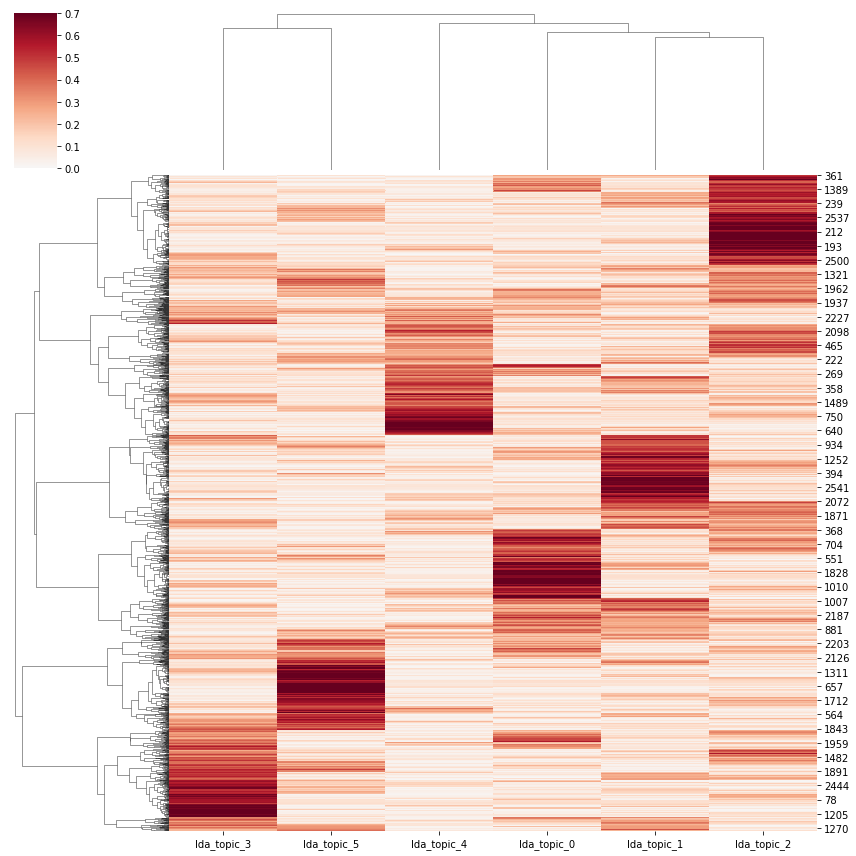

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(df, center=0, standard_scale=1, 
                   cmap="RdBu_r", metric='cosine',
                   vmax = 0.7, vmin = 0,
                   figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [160]:
n = 1311
[(id2word[id], freq) for id, freq in corpus[n]]

[('todays', 1),
 ('rocket', 1),
 ('space', 1),
 ('land', 1),
 ('droneship', 1),
 ('fast', 1),
 ('replay', 1),
 ('oily', 1)]

In [161]:
doc_lda[n][0]

[(0, 0.07278588),
 (1, 0.08102079),
 (2, 0.09577529),
 (3, 0.21234469),
 (4, 0.05954299),
 (5, 0.47853038)]

In [162]:
tweets_entrenamiento[n]

"Fast replay of today's rocket landing on SpaceX droneship OCISLY\nhttps://t.co/I0QQ2D3BtE"

In [172]:
n = 657
[(id2word[id], freq) for id, freq in corpus[n]]

[('falcon', 1), ('first_stage', 1), ('land', 1), ('lz', 1)]

In [173]:
doc_lda[n][0]

[(0, 0.10011807),
 (1, 0.111441575),
 (2, 0.13174044),
 (3, 0.103962384),
 (4, 0.081899256),
 (5, 0.47083825)]

In [174]:
tweets_entrenamiento[n]


'RT @SpaceX: Falcon 9 first stage has landed at LZ-1'

In [180]:
n = 1712
[(id2word[id], freq) for id, freq in corpus[n]]

[('unveil', 1),
 ('worlds', 1),
 ('solar', 1),
 ('leon_musk', 1),
 ('panel', 1),
 ('efficient', 1)]

In [181]:
doc_lda[n][0]

[(0, 0.08429445),
 (1, 0.17312475),
 (2, 0.1902195),
 (3, 0.08753137),
 (4, 0.06897016),
 (5, 0.39585975)]